In [ ]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import albumentations as A
import seaborn as sns

3.4600903348681196


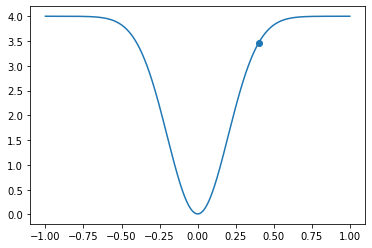

In [ ]:
def normal_dist(x , mean , sd):
    prob_density = 1/(sd*np.sqrt(2*np.pi))* np.exp(-0.5*((x-mean)/(2*sd))**2)
    return prob_density

x = np.arange(-1, 1, 0.001)
p = 0.4
dist = normal_dist(x,0,0.1)
point = normal_dist(p,0,0.1)
m = 4
# m = max(dist)
real = m-dist 

print(m-point)

# plt.plot(x,dist)
plt.scatter(p,m-point)
plt.plot(x,real)
plt.show()

In [ ]:
import torch

a =  torch.tensor([[[1.,1.]],[[11.,11.]],[[1.,1.]],[[1.,1.]]])
b = torch.tensor([[[2.,2.]],[[2.,2.]],[[2.,2.]],[[2.,2.]]])

euc = torch.cdist(a,b)
print(euc)

tensor([[[ 1.4142]],

        [[12.7279]],

        [[ 1.4142]],

        [[ 1.4142]]])


In [ ]:
_,train_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/img/", ".png")
_,test_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/img/", ".png")

# d_path, d_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_imgs", ".png")

# test_out = "/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/depth/"
# train_out = "/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/depth/"

# def _replace_text(list, oldtext, newtext):
#     newlist = []
#     for name in list:
#         name = name.replace(oldtext,newtext)
#         newlist.append(name)
#     return newlist

# train_d_list = _replace_text(train_name, "rgb", "depth")
# test_d_list = _replace_text(test_name, "rgb", "depth")

# tc, tec = 0,0

# for idx, name in enumerate(d_name):
#     # print(name)
#     if "depth" in name:
#         if name in test_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],test_out+f"{name}")
#                 tec += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass
#         if name in train_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],train_out+f"{name}")
#                 tc += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass

# print(f"train {tc} test {tec}")

In [ ]:
train_path_d,train_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/depth/", ".png")
_,test_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/depth/", ".png")

In [ ]:
i = np.random.randint(0,20)
i2 = np.random.randint(0,111)

print(test_name_d[i])
print(test_name[i])
print(train_name_d[i2])
print(train_name[i2])

20200806_stengard_depth_1_1628244333438315153.png
20200806_stengard_rgb_1_1628244333438315153.png
20200806_stengard_depth_0_1628243926579842091.png
20200806_stengard_rgb_0_1628243926579842091.png


In [ ]:
image = cv2.imread(train_path_d[3], cv2.IMREAD_UNCHANGED )
transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000)])
image = transform(image=image)
image = image['image']
non_zero_image = image[image!=0]
# cv_image_norm = cv2.normalize(non_zero_image, non_zero_image, 0, 1, cv2.NORM_MINMAX)
# print(non_zero_image.min())
# plt.hist(non_zero_image.ravel(),bins=100);

ax = sns.heatmap(non_zero_image, linewidth=0.5)
plt.show()


NameError: name 'sns' is not defined